In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

In [2]:
def parser(x):
    return datetime.strptime(x, '%d-%m-%Y')
 
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [3]:
series = read_csv('sales_data.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
print(series.head())

              Sales
2012-01-01   1317.0
2012-02-01   2883.0
2012-03-01   6698.0
2012-04-01  10263.0
2012-05-01  13630.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13428\148902392.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  series = read_csv('sales_data.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


In [4]:
raw_values = series.values
diff_values = difference(raw_values, 1)
 
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# 6 months training, 2 months testing
train, test = supervised_values[0:-24], supervised_values[-24:]
 
scaler, train_scaled, test_scaled = scale(train, test)
 
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)




71/71 [==============================] - 0s 1ms/step


array([[-0.9877851 ],
       [-0.8701571 ],
       [-0.77322876],
       [-0.74981874],
       [-0.8017163 ],
       [-0.79455215],
       [-0.8317634 ],
       [-0.6268297 ],
       [-0.5904706 ],
       [-0.45083112],
       [-0.4771064 ],
       [-0.36485672],
       [-0.65797555],
       [-0.54718775],
       [-0.41407645],
       [-0.43272132],
       [-0.41185594],
       [-0.36692536],
       [-0.40356362],
       [-0.33675468],
       [-0.32020772],
       [-0.3054608 ],
       [-0.31604707],
       [-0.30536026],
       [-0.5106318 ],
       [-0.44394612],
       [-0.33027303],
       [-0.3256458 ],
       [-0.36745852],
       [-0.34451002],
       [-0.3032307 ],
       [-0.34495777],
       [-0.30024153],
       [-0.29195237],
       [-0.2930674 ],
       [-0.424201  ],
       [-0.5122891 ],
       [-0.4449247 ],
       [-0.30708712],
       [-0.28466034],
       [-0.29508018],
       [-0.25412256],
       [-0.2384529 ],
       [-0.21160255],
       [-0.17029558],
       [-0

In [5]:
predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 25ms/step
Month=1, Predicted=758493.526721, Expected=759090.000000
1/1 [==============================] - 0s 25ms/step
Month=2, Predicted=774213.587754, Expected=775935.000000
1/1 [==============================] - 0s 25ms/step
Month=3, Predicted=794188.704181, Expected=802378.000000
1/1 [==============================] - 0s 24ms/step
Month=4, Predicted=813274.700238, Expected=822001.000000
1/1 [==============================] - 0s 26ms/step
Month=5, Predicted=837243.302432, Expected=846308.000000
1/1 [==============================] - 0s 25ms/step
Month=6, Predicted=859039.283899, Expected=871337.000000
1/1 [==============================] - 0s 20ms/step
Month=7, Predicted=884216.535097, Expected=900935.000000
1/1 [==============================] - 0s 33ms/step
Month=8, Predicted=913790.603773, Expected=937282.000000
1/1 [==============================] - 0s 25ms/step
Month=9, Predicted=949998.031506, Expected=981826.000000
1/1 [==============

In [6]:
rmse = sqrt(mean_squared_error(raw_values[-24:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18447.399


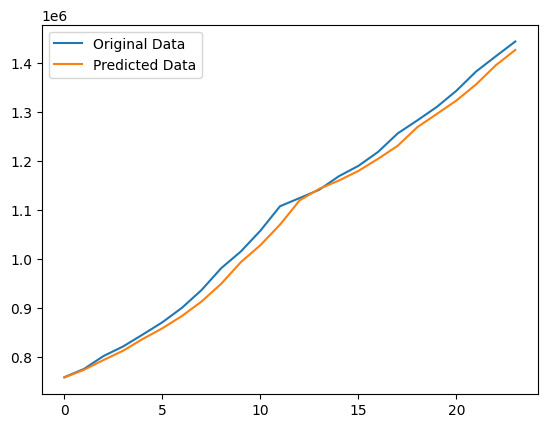

In [7]:
pyplot.plot(raw_values[-24:], label='Original Data')
pyplot.plot(predictions, label='Predicted Data')
pyplot.legend()
pyplot.show()

In [8]:
lstm_model.predict(train_reshaped, batch_size=1)

71/71 [==============================] - 0s 1ms/step


array([[-1.3380319 ],
       [-0.72835845],
       [-0.8698524 ],
       [-0.68353224],
       [-0.87618434],
       [-0.72326916],
       [-0.9063772 ],
       [-0.574726  ],
       [-0.62882435],
       [-0.44052732],
       [-0.48757768],
       [-0.3674481 ],
       [-0.663948  ],
       [-0.54518193],
       [-0.4149416 ],
       [-0.43244523],
       [-0.41204756],
       [-0.367055  ],
       [-0.40372133],
       [-0.3369022 ],
       [-0.32039368],
       [-0.30567616],
       [-0.31636405],
       [-0.30572814],
       [-0.51122314],
       [-0.44458586],
       [-0.3309099 ],
       [-0.32663095],
       [-0.36808825],
       [-0.34528857],
       [-0.3044504 ],
       [-0.3461252 ],
       [-0.30223495],
       [-0.2951383 ],
       [-0.29753816],
       [-0.42562926],
       [-0.5169035 ],
       [-0.45254928],
       [-0.31482738],
       [-0.2971031 ],
       [-0.30665255],
       [-0.27105725],
       [-0.26667804],
       [-0.2546084 ],
       [-0.2254753 ],
       [-0

In [11]:
yhat = forecast_lstm(lstm_model, 1, X)
print(yhat)

1/1 [==============================] - 0s 16ms/step
-0.28394127


In [12]:
X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
yhat = invert_scale(scaler, X, yhat)
yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)

In [13]:
print(raw_values)

[[1.317000e+03]
 [2.883000e+03]
 [6.698000e+03]
 [1.026300e+04]
 [1.363000e+04]
 [1.675400e+04]
 [1.978300e+04]
 [2.446900e+04]
 [3.021400e+04]
 [3.729800e+04]
 [4.405300e+04]
 [5.260700e+04]
 [5.718400e+04]
 [6.258800e+04]
 [7.057000e+04]
 [7.770800e+04]
 [8.516200e+04]
 [9.345400e+04]
 [1.008460e+05]
 [1.121190e+05]
 [1.210460e+05]
 [1.311010e+05]
 [1.401040e+05]
 [1.501140e+05]
 [1.557940e+05]
 [1.628240e+05]
 [1.724740e+05]
 [1.813690e+05]
 [1.937310e+05]
 [2.057940e+05]
 [2.170360e+05]
 [2.292080e+05]
 [2.401290e+05]
 [2.498680e+05]
 [2.595140e+05]
 [2.725520e+05]
 [2.786090e+05]
 [2.855600e+05]
 [2.959010e+05]
 [3.049950e+05]
 [3.165350e+05]
 [3.268990e+05]
 [3.358500e+05]
 [3.448220e+05]
 [3.549560e+05]
 [3.648820e+05]
 [3.749520e+05]
 [3.886510e+05]
 [3.948720e+05]
 [4.026350e+05]
 [4.164920e+05]
 [4.270230e+05]
 [4.384900e+05]
 [4.533530e+05]
 [4.664200e+05]
 [4.810120e+05]
 [4.982360e+05]
 [5.092430e+05]
 [5.224800e+05]
 [5.472650e+05]
 [5.582700e+05]
 [5.706470e+05]
 [5.8918

In [14]:
print(predictions)

[array([758493.52672062]), array([774213.587754]), array([794188.70418128]), array([813274.70023776]), array([837243.3024323]), array([859039.28389887]), array([884216.53509658]), array([913790.60377309]), array([949998.03150586]), array([994069.90646378]), array([1028862.91901354]), array([1070803.56184924]), array([1120384.96301018]), array([1143960.06591448]), array([1160812.6829925]), array([1180611.25841636]), array([1205205.90556158]), array([1231812.86204012]), array([1269772.17492602]), array([1296945.83320915]), array([1324457.01776939]), array([1357309.4263492]), array([1396178.53674067]), array([1427603.75359889])]


In [15]:
import numpy as np
num_future_steps = 12  

future_predictions = []
last_observed_values = test_scaled[-1, 1:] 

for i in range(num_future_steps):
    yhat = forecast_lstm(lstm_model, 1, last_observed_values)
    yhat = invert_scale(scaler, last_observed_values, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 2 + i) 
    future_predictions.append(yhat)
    last_observed_values = np.append(last_observed_values[1:], yhat)

print("Predicted values for the future time steps:\n",future_predictions)

1/1 [==============================] - 0s 16ms/step
Predicted values for the future time steps:
 [array([733821.02231575]), array([711733.09840825]), array([697418.09840825]), array([676176.09840825]), array([659662.09840825]), array([644122.09840825]), array([627076.09840825]), array([610480.09840825]), array([597115.09840825]), array([578574.09840825]), array([566197.09840825]), array([555192.09840825])]
